# 00c - Extract ISIMIP3b glacier climate change informations:
- creates glacier area-weighted temperature changes (globally or per RGI region) : `../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv`
    - at the moment it gives the "temp. change comparaed to preindustrial times" in the following way: "assumes" that regional/glacier temp. change is also +0.69°C between 1850 and "(1986, 2005)" and then just estimates the average temperature change of the experimental period to that reference period "(1986, 2005)"
    - PROBLEM: how to define the temperature change. Can we do it the same as done for the global temperature change of the IPCC report with the assumption of +0.69°C of temperature change having occured until 1986-2005? Not really, but it is difficult to find a better solution...
        - for the moment we just assume that temperature change is the same regionally (as globally) from preindustrial to 1986-2005
        - alternative: just compute the diffference experimental period - (1986, 2005) (because this is the period of interest anyways ... (but then it is more complicated to compare with the global warming)
- also: analysis of projected climate changes on glacier level

**Updated to 0.69 estimate: Note that 0.63 was used in IPCC SROCC and Rounce et al., 2023 for the warming between 1850-1900 and 1986-2005. We use the more recent IPCC AR6 estimate of 0.69°C.**

- there are some plots showing temperature changes of the different glacier regions for different gcms and scenarios. This will be helpful for the interpretation of the glacier projections later on. Some plots use another definition of "temperature change" and can be updated, if they are interesting, to the IPCC definition 

---

In [3]:
# path to isimip3b files that are available under https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/: this needs to be changed if not run used on the OGGM cluster
path = '/home/www/lschuster/isimip3b/'

In [4]:
import xarray as xr
import numpy as np
from oggm import utils
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import progressbar
from scipy import stats
import seaborn as sns

# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## some preprocessing to get the glacier gridpoints and their area
- we take the lon/lat gridpoints nearest to the glaciers and create a mask to get later the climate just for those glacier gridpoints. This mask can either be applied to get a global climate change over glacier estimate or a regional estimate 

In [5]:
# updated to new version 2023.2
ds_inv = xr.open_dataset(path+'orog_W5E5v2.0.nc')
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = path + 'rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
# remove those glaciers with connectivity level not at 0 or 1 in RGI region 05:
# check if all glaciers with connectivity level not in 0 or 1 are in RGI region 05 
assert np.all(odf.loc[(odf.Connect != 0) & (odf.Connect != 1)].O1Region == '05')
# ok then just select those glaciers with the right connectivity level ...
odf = odf.loc[(odf.Connect == 0) | (odf.Connect == 1)]


nx, ny = ds_inv.dims['lon'], ds_inv.dims['lat']
# just make them into 0-> 360 scheme
cenlon_for_bins = np.where(odf['CenLon'] < 0,
                           odf['CenLon']+360, odf['CenLon'])
# Nearest neighbor lookup
lon_bins = np.linspace(ds_inv.lon.data[0] - 0.25, ds_inv.lon.data[-1] + 0.25, nx+1)
# !!! attention W5E5 sorted from 90 to -90 !!!!
lat_bins = np.linspace(ds_inv.lat.data[0] + 0.25, ds_inv.lat.data[-1] - 0.25, ny+1)
# before it was wrongly 
# lon_bins = np.linspace(0, 360, nx), lat_bins = np.linspace(90, -90, ny)
# which created a non-aligned bins, in addition there was one bin missing, creating a slightly 
# larger resolution which after adding up a lot got problematic... 
# at the end it resulted in some glaciers where the nearest grid point was not found

odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1

# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of W5E5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_inv['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

ds_inv['glacier_area'] = (('lat', 'lon'), mask)
ds_inv['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_inv['rgi_region'] = (('lat', 'lon'), reg)


# check the distance to the gridpoints-> it should never be larger than 
diff_lon = ds_inv.lon.data[odf.lon_id] - odf.CenLon
# if the distance is 360 -> it is the same as 0,
diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_inv.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
assert odf['ll_dist_to_point'].max() < (0.25**2 + 0.25**2)**0.5

# Normal Weight
weight = np.cos(np.deg2rad(ds_inv.lat.astype(np.float64))).clip(0)
weight =  ds_inv.orog * 0. + weight
ds_inv['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)

/tmp/ipykernel_790705/3497108456.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx, ny = ds_inv.dims['lon'], ds_inv.dims['lat']


Total number of glaciers: 215547 and number of W5E5 gridpoints with glaciers in them: 4695


In [6]:
print('total glacier area: {} km2'.format(np.nansum(mask)) )

total glacier area: 705738.792 km2


In [7]:
# this should be one
print(ds_inv['weight_glacier'].sum())

<xarray.DataArray 'weight_glacier' ()> Size: 8B
array(1.)


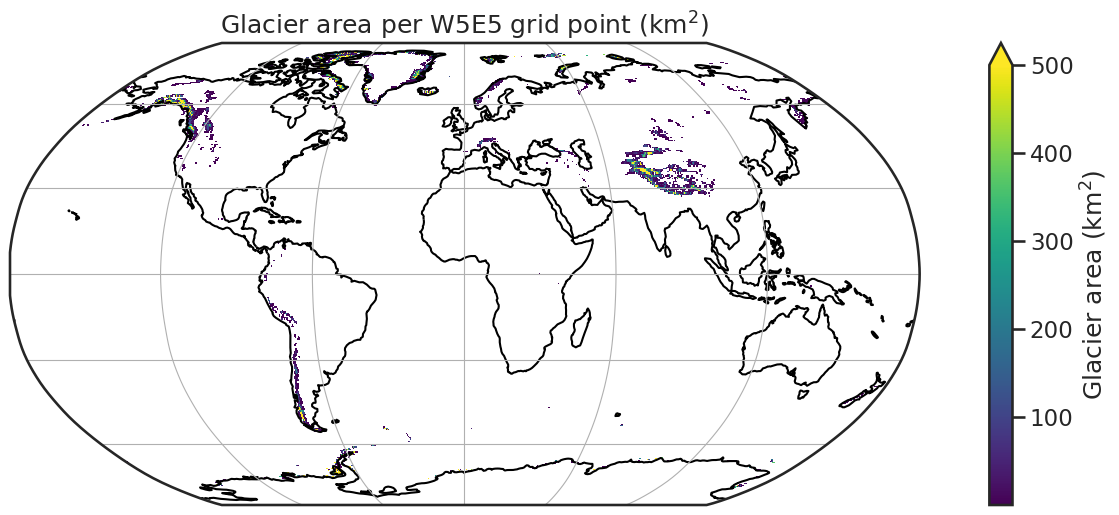

In [8]:
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                            cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per W5E5 grid point (km$^{2}$)');

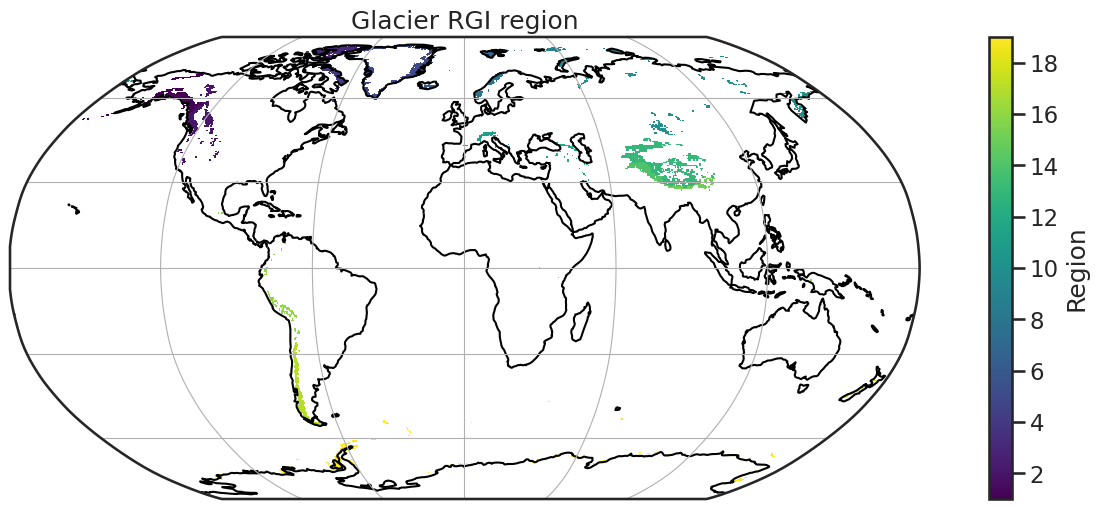

In [9]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['rgi_region'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                            cbar_kwargs={'label':'Region'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier RGI region');

## ISIMIP3b average Temperature change at glacier locations for each region separately (using IPCC definition)

- PROBLEM: --> regional temperature change definition???

In [10]:
exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the right format for the longitudes
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['ssp126', 'ssp370', 'ssp585']

# weighted average over latitudes
weight_regions = {}
weight_regions['global'] = ds_inv.weight #.sum(dim='lon')

# this is glacier area weighted
weight_regions['global_glacier']  = ds_inv.weight_glacier# .sum(dim='lon')
# the glacier regional weight files need to be longitude dependent!!!
for rgi_reg in range(1, 20):
    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
    weight_reg = weight_reg / weight_reg.sum()
    weight_regions[f'RGI{rgi_reg:02g}_glacier'] = weight_reg #.sum(dim='lon')
regions = weight_regions.keys()

In [12]:
run = False
if run:
    pd_global_temp_exp = pd.DataFrame(columns=['gcm', 'period_scenario', 'temp_ch_ipcc'])

    typ = 'tasAdjust'
    temp_change_l = []
    #temp_change_l_from_1986_2005 = [] 
    period_scenario_l =[]
    gcm_l = []
    region_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'


        folder_output = 'isimip3b_{}_monthly'.format(typ)
            
        for region in regions:
            ybegin = 1850
            yend = 2014
            scenario = 'hist'
            path_output = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble,
                                                                                      'historical', typ, ybegin, yend)
            with xr.open_dataset(path_output) as ds_tas_yearly:
                ds_tas_yearly = ds_tas_yearly.groupby('time.year').mean().load()
                
            #this needs to be the same as the weight!!!
            ds_tas_yearly.coords['lon'] = np.where(ds_tas_yearly.lon.values < 0, ds_tas_yearly.lon.values + 360,
                                  ds_tas_yearly.lon.values)
            ds_tas_yearly = ds_tas_yearly.sortby(ds_tas_yearly.lon)

            weight_sel = weight_regions[region]
            np.testing.assert_allclose(weight_sel.lon.values, ds_tas_yearly.lon.values)
            np.testing.assert_allclose(weight_sel.sum(),1)

            global_tas_mean = (ds_tas_yearly.tasAdjust * weight_sel).sum(dim='lon').sum(dim='lat') - 273.15  # from K to °C
            if region == 'global':
                global_tas_mean_test = (ds_tas_yearly.tasAdjust.mean(dim='lon') * weight_sel.sum(dim='lon')).sum(dim='lat') - 273.15  # from K to °C
                np.testing.assert_allclose(global_tas_mean, global_tas_mean_test, rtol=1e-3)
            ref_period_avg = global_tas_mean.sel(year = slice(str(1986),str(2005))).mean()

            for exp_time in exp_times[:4]:
                exp_period_avg = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
                gcm_l.append(gcm)
                period_scenario_l.append(f'{str(exp_time)}-{str(exp_time+19)}_{scenario}')
                temp_change_l.append((exp_period_avg-ref_period_avg + 0.69).values)  # 0.63 was used in IPCC SROCC and Rounce et al., 2023-> but we changed it here to more recent IPCC AR6 estimate of 0.69°C
                region_l.append(region)

            for scenario in scenarios:
                ybegin = 2015
                yend = 2100
                path_output_f = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario,
                                                                                                typ, ybegin, yend)

                with xr.open_dataset(path_output_f) as ds_tas_yearly_f:
                    ds_tas_yearly_f = ds_tas_yearly_f.groupby('time.year').mean().load()
                    # this needs to be the same as the weight!!!
                    ds_tas_yearly_f.coords['lon'] = np.where(ds_tas_yearly_f.lon.values < 0,
                                                             ds_tas_yearly_f.lon.values + 360, ds_tas_yearly_f.lon.values)
                    ds_tas_yearly_f = ds_tas_yearly_f.sortby(ds_tas_yearly_f.lon)
                    
                    #global_tas_mean_f = (ds_tas_yearly_f.tasAdjust.mean(dim='lon') * weight_sel).sum(dim='lat') - 273.15  # from K to °C
                    global_tas_mean_f = (ds_tas_yearly_f.tasAdjust * weight_sel).sum(dim='lon').sum(dim='lat') - 273.15  # from K to °C

                for exp_time in exp_times[4:]:
                    exp_period_avg = global_tas_mean_f.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
                    gcm_l.append(gcm)
                    period_scenario_l.append(f'{str(exp_time)}-{str(exp_time+19)}_{scenario}')
                    temp_change_l.append((exp_period_avg-ref_period_avg + 0.69).values) # 0.63 was used in IPCC SROCC and Rounce et al., 2023-> but we changed it here to more recent IPCC AR6 estimate of 0.69°C
                    region_l.append(region)
            ds_tas_yearly_f.close()
        ds_tas_yearly.close()
        print('t')
    pd_global_temp_exp['gcm'] = gcm_l
    pd_global_temp_exp['period_scenario'] = period_scenario_l
    pd_global_temp_exp[f'temp_ch_ipcc'] = np.array(temp_change_l)
    pd_global_temp_exp['region'] = region_l
    pd_global_temp_exp.to_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv')
else:
    pd_global_temp_exp = pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col=[0])
    
pd_global_true_temp_exp = pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)
_glob = pd_global_temp_exp.loc[pd_global_temp_exp.region == 'global']
np.testing.assert_allclose(_glob['temp_ch_ipcc'].values,pd_global_true_temp_exp['temp_ch_ipcc'].values, rtol=1e-5)
assert np.all(_glob['gcm'].values==pd_global_true_temp_exp['gcm'].values)
assert np.all(_glob['period_scenario'].values==pd_global_true_temp_exp['period_scenario'].values)
pd_global_temp_exp

,gcm,period_scenario,temp_ch_ipcc,region
0,gfdl-esm4,1851-1870_hist,0.231409,global
1,gfdl-esm4,1901-1920_hist,0.478289,global
2,gfdl-esm4,1951-1970_hist,0.392281,global
3,gfdl-esm4,1995-2014_hist,0.901467,global
4,gfdl-esm4,2021-2040_ssp126,1.493792,global
...,...,...,...,...
1675,ukesm1-0-ll,2081-2100_ssp370,7.123570,RGI19_glacier
1676,ukesm1-0-ll,2021-2040_ssp585,2.362103,RGI19_glacier
1677,ukesm1-0-ll,2041-2060_ssp585,3.988220,RGI19_glacier
1678,ukesm1-0-ll,2061-2080_ssp585,5.739617,RGI19_glacier


**TODO: maybe change to 1986-2005**

In [17]:
pd_global_temp_exp['temp_ch_1986_2005'] = pd_global_temp_exp.temp_ch_ipcc-0.69

In [39]:
print('reg', 'ratio_1986_2005','ratio_old')
_glob = pd_global_temp_exp.loc[pd_global_temp_exp.region=='global'].set_index(['gcm','period_scenario'])
for region in pd_global_temp_exp.region.unique():
    _reg = pd_global_temp_exp.loc[pd_global_temp_exp.region==region].set_index(['gcm','period_scenario'])
    print(region,
          np.round((_reg.loc[_glob.index, 'temp_ch_1986_2005']/_glob['temp_ch_1986_2005']).median(),2),
          np.round((_reg.loc[_glob.index, 'temp_ch_ipcc']/_glob['temp_ch_ipcc']).median(),2))

reg ratio_1986_2005 ratio_old
global 1.0 1.0
global_glacier 1.81 1.54
RGI01_glacier 1.48 1.28
RGI02_glacier 1.34 1.23
RGI03_glacier 2.42 1.98
RGI04_glacier 2.22 1.79
RGI05_glacier 1.88 1.61
RGI06_glacier 0.94 0.94
RGI07_glacier 2.97 2.51
RGI08_glacier 1.28 1.21
RGI09_glacier 3.12 2.54
RGI10_glacier 1.7 1.45
RGI11_glacier 1.37 1.26
RGI12_glacier 1.41 1.3
RGI13_glacier 1.38 1.26
RGI14_glacier 1.36 1.24
RGI15_glacier 1.2 1.14
RGI16_glacier 1.2 1.1
RGI17_glacier 0.7 0.79
RGI18_glacier 0.82 0.85
RGI19_glacier 1.1 1.02


***Future experiments***

/tmp/ipykernel_790705/3005793861.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
/tmp/ipykernel_790705/3005793861.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
/tmp/ipykernel_790705/3005793861.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
/tmp/ipykernel_790705/3005793861.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hu

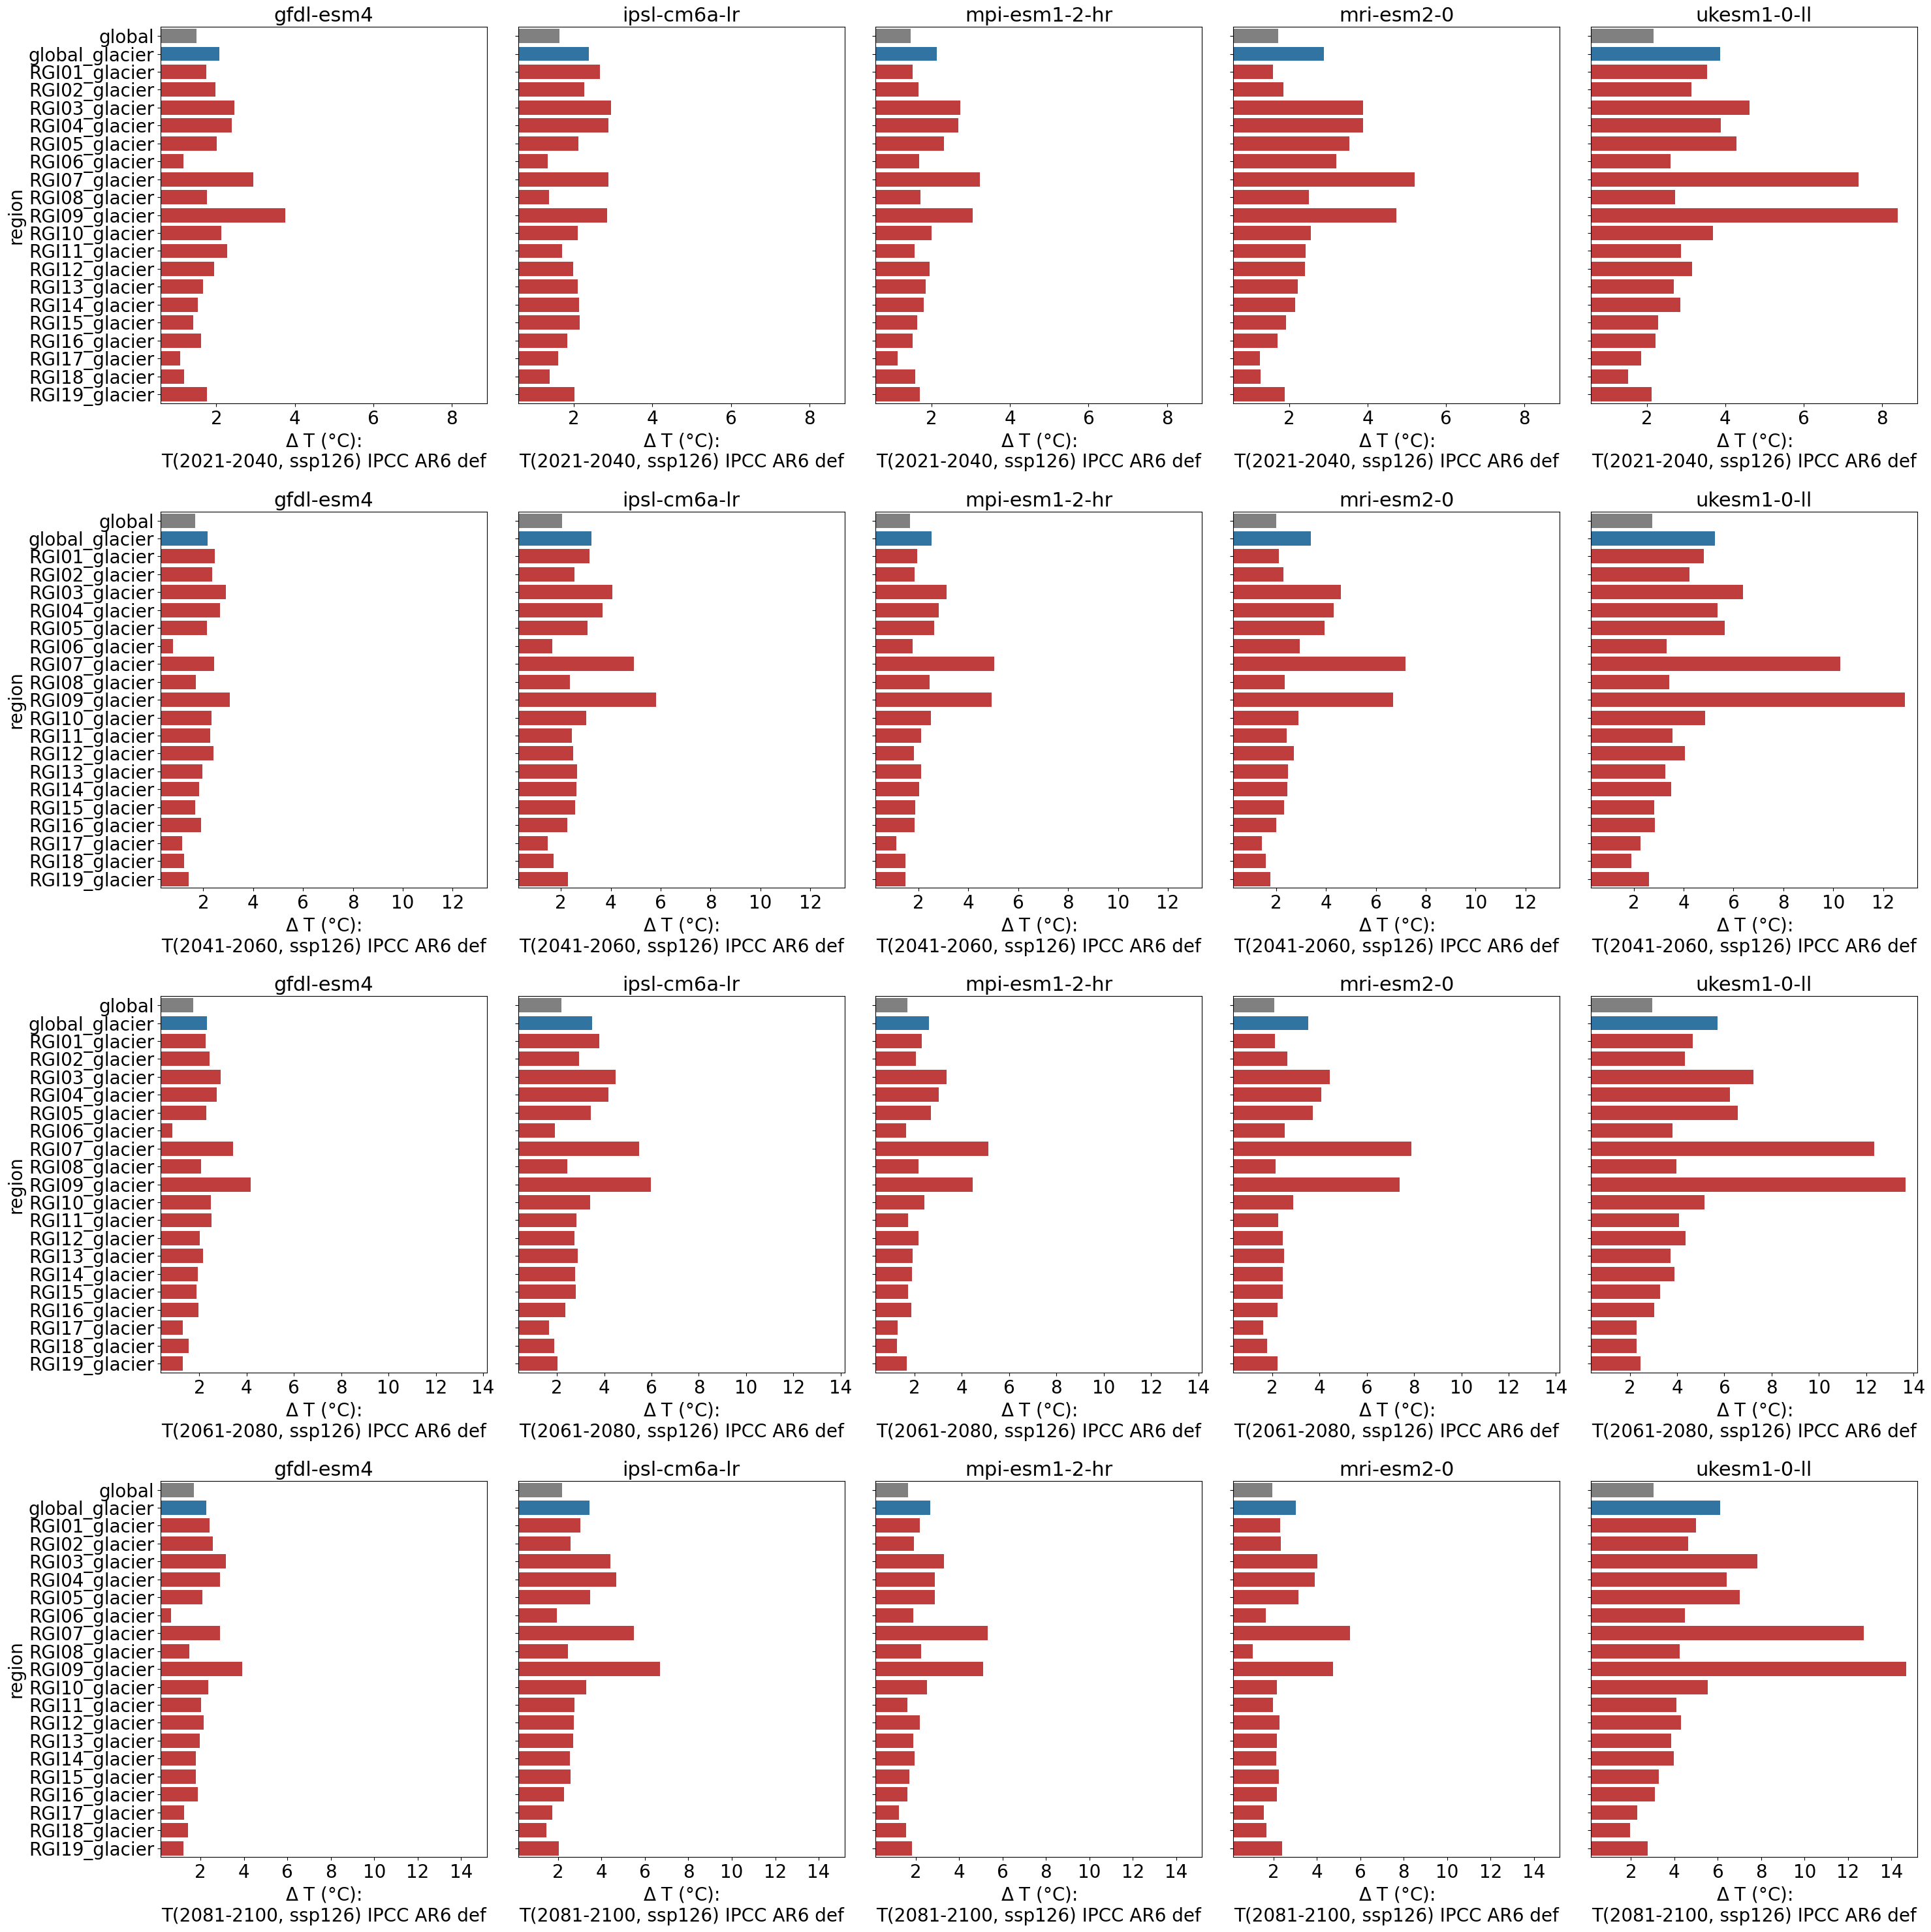

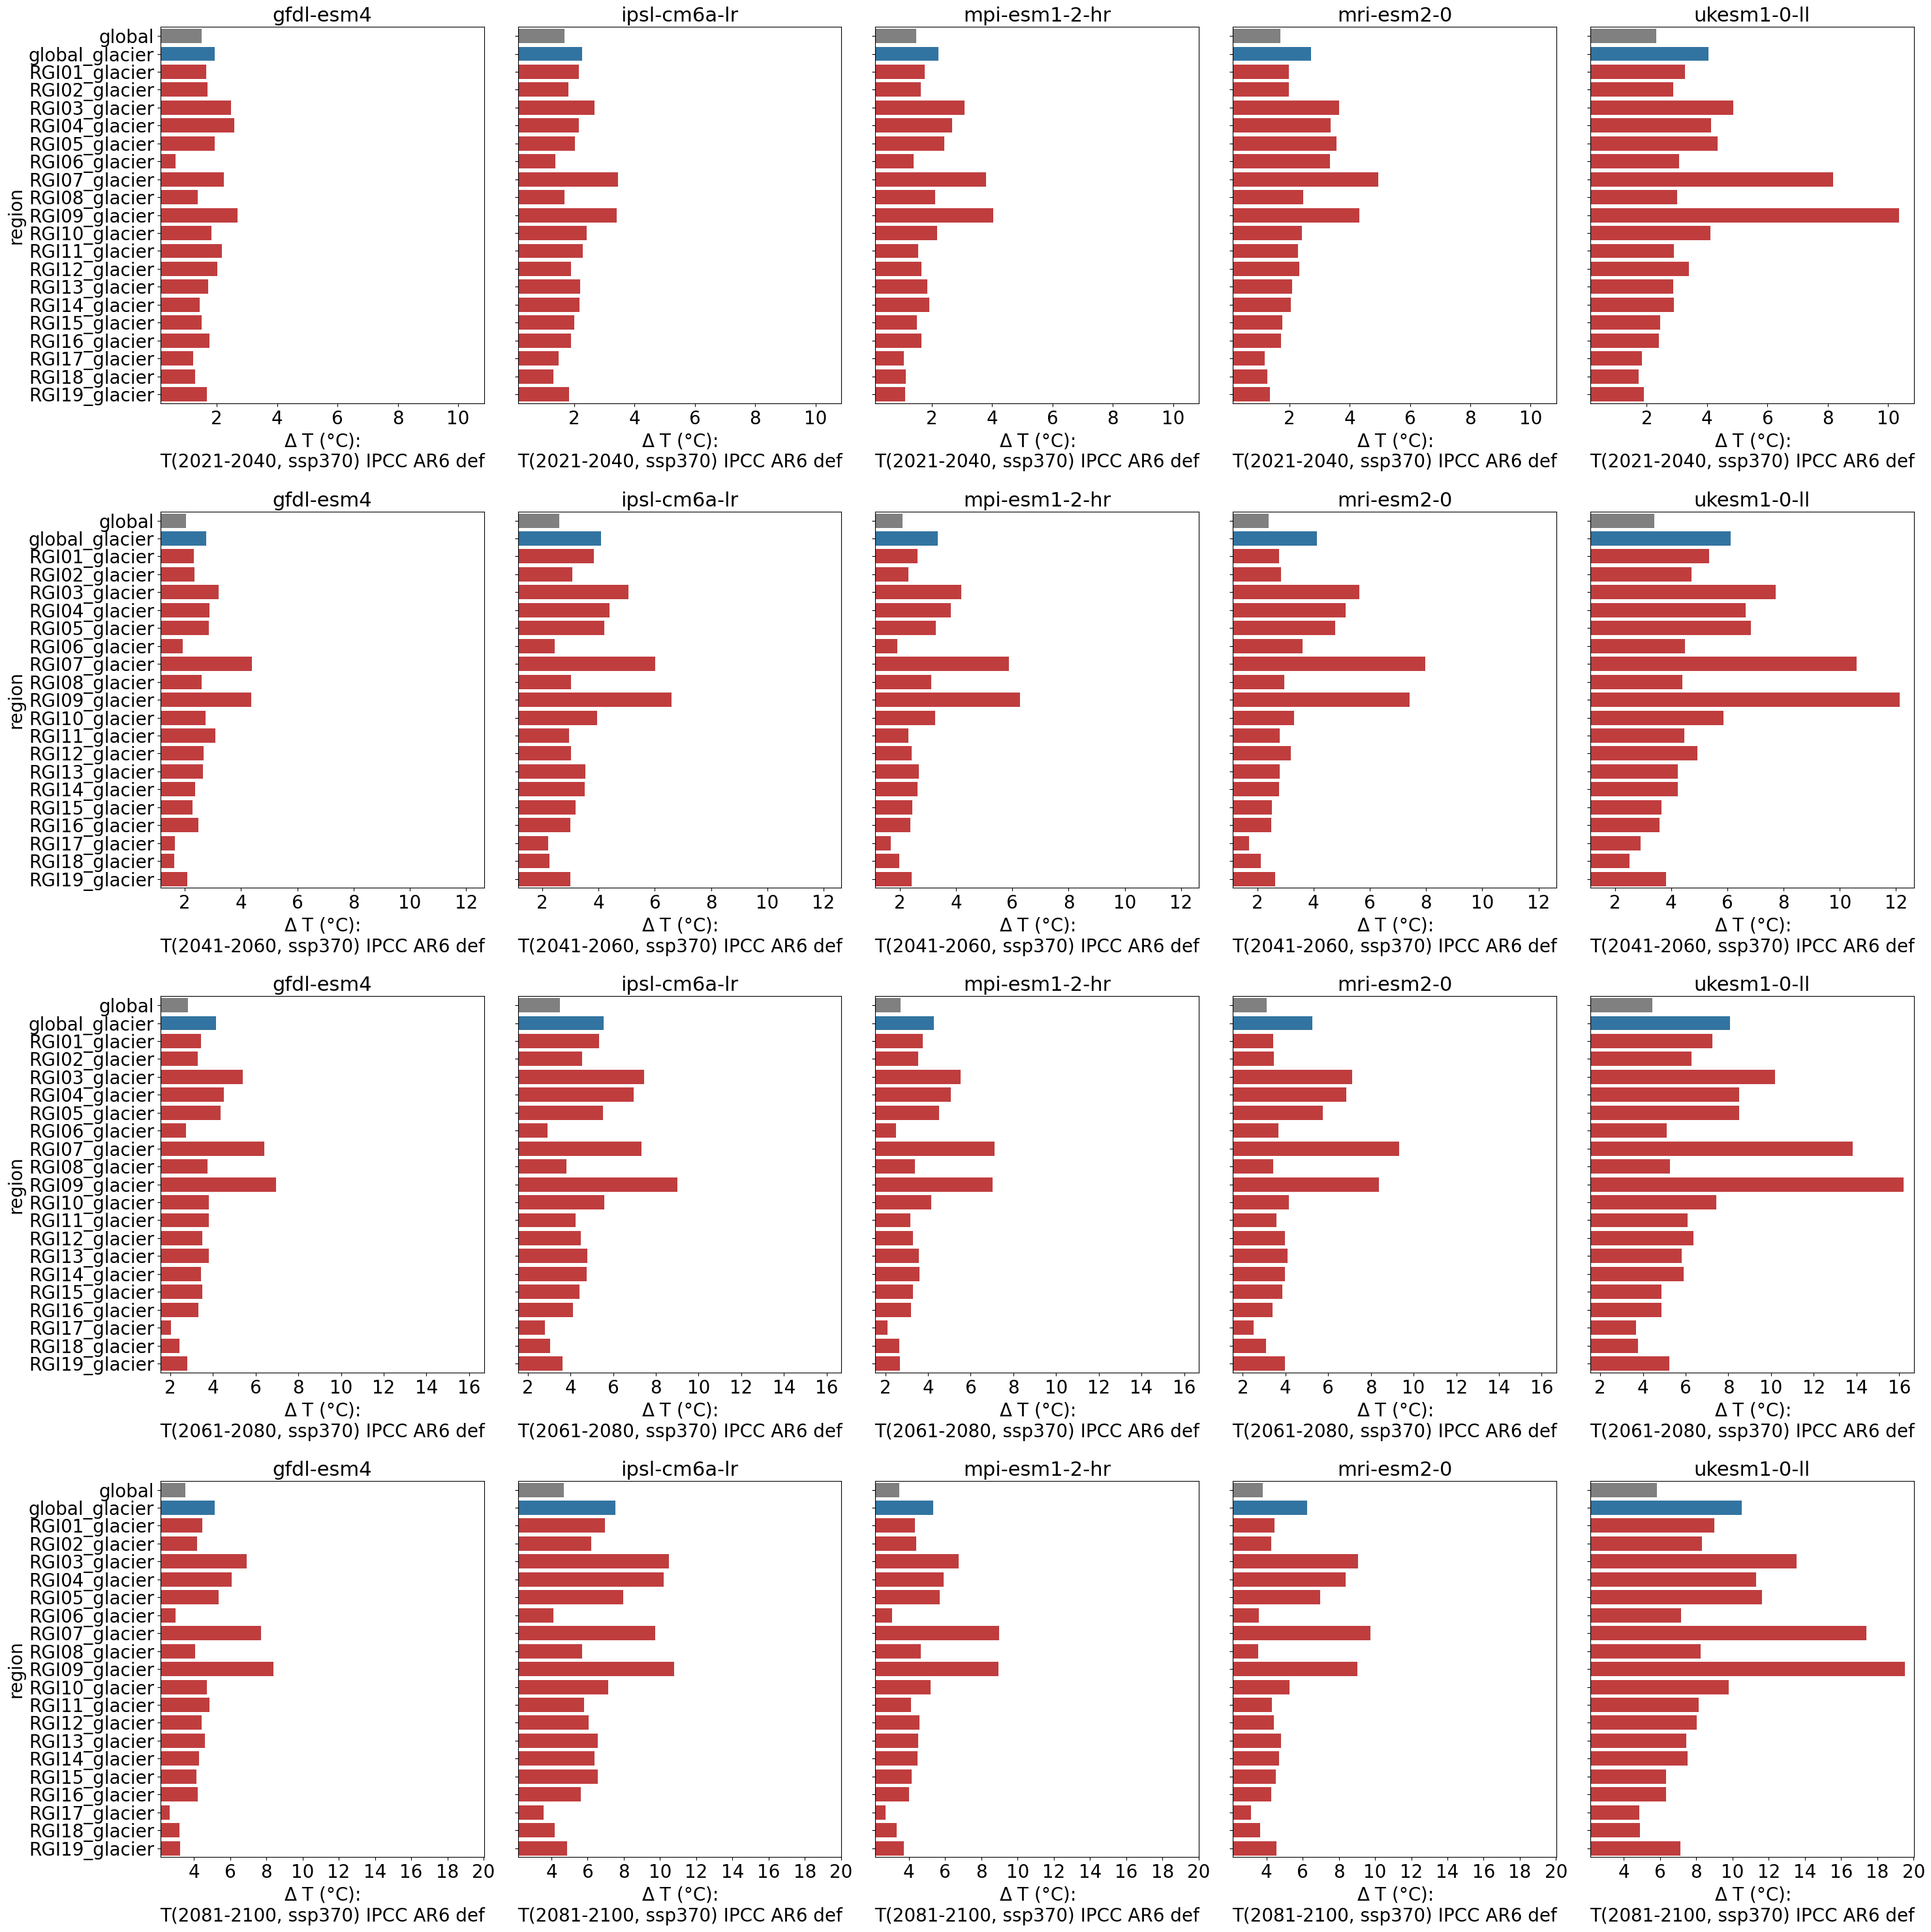

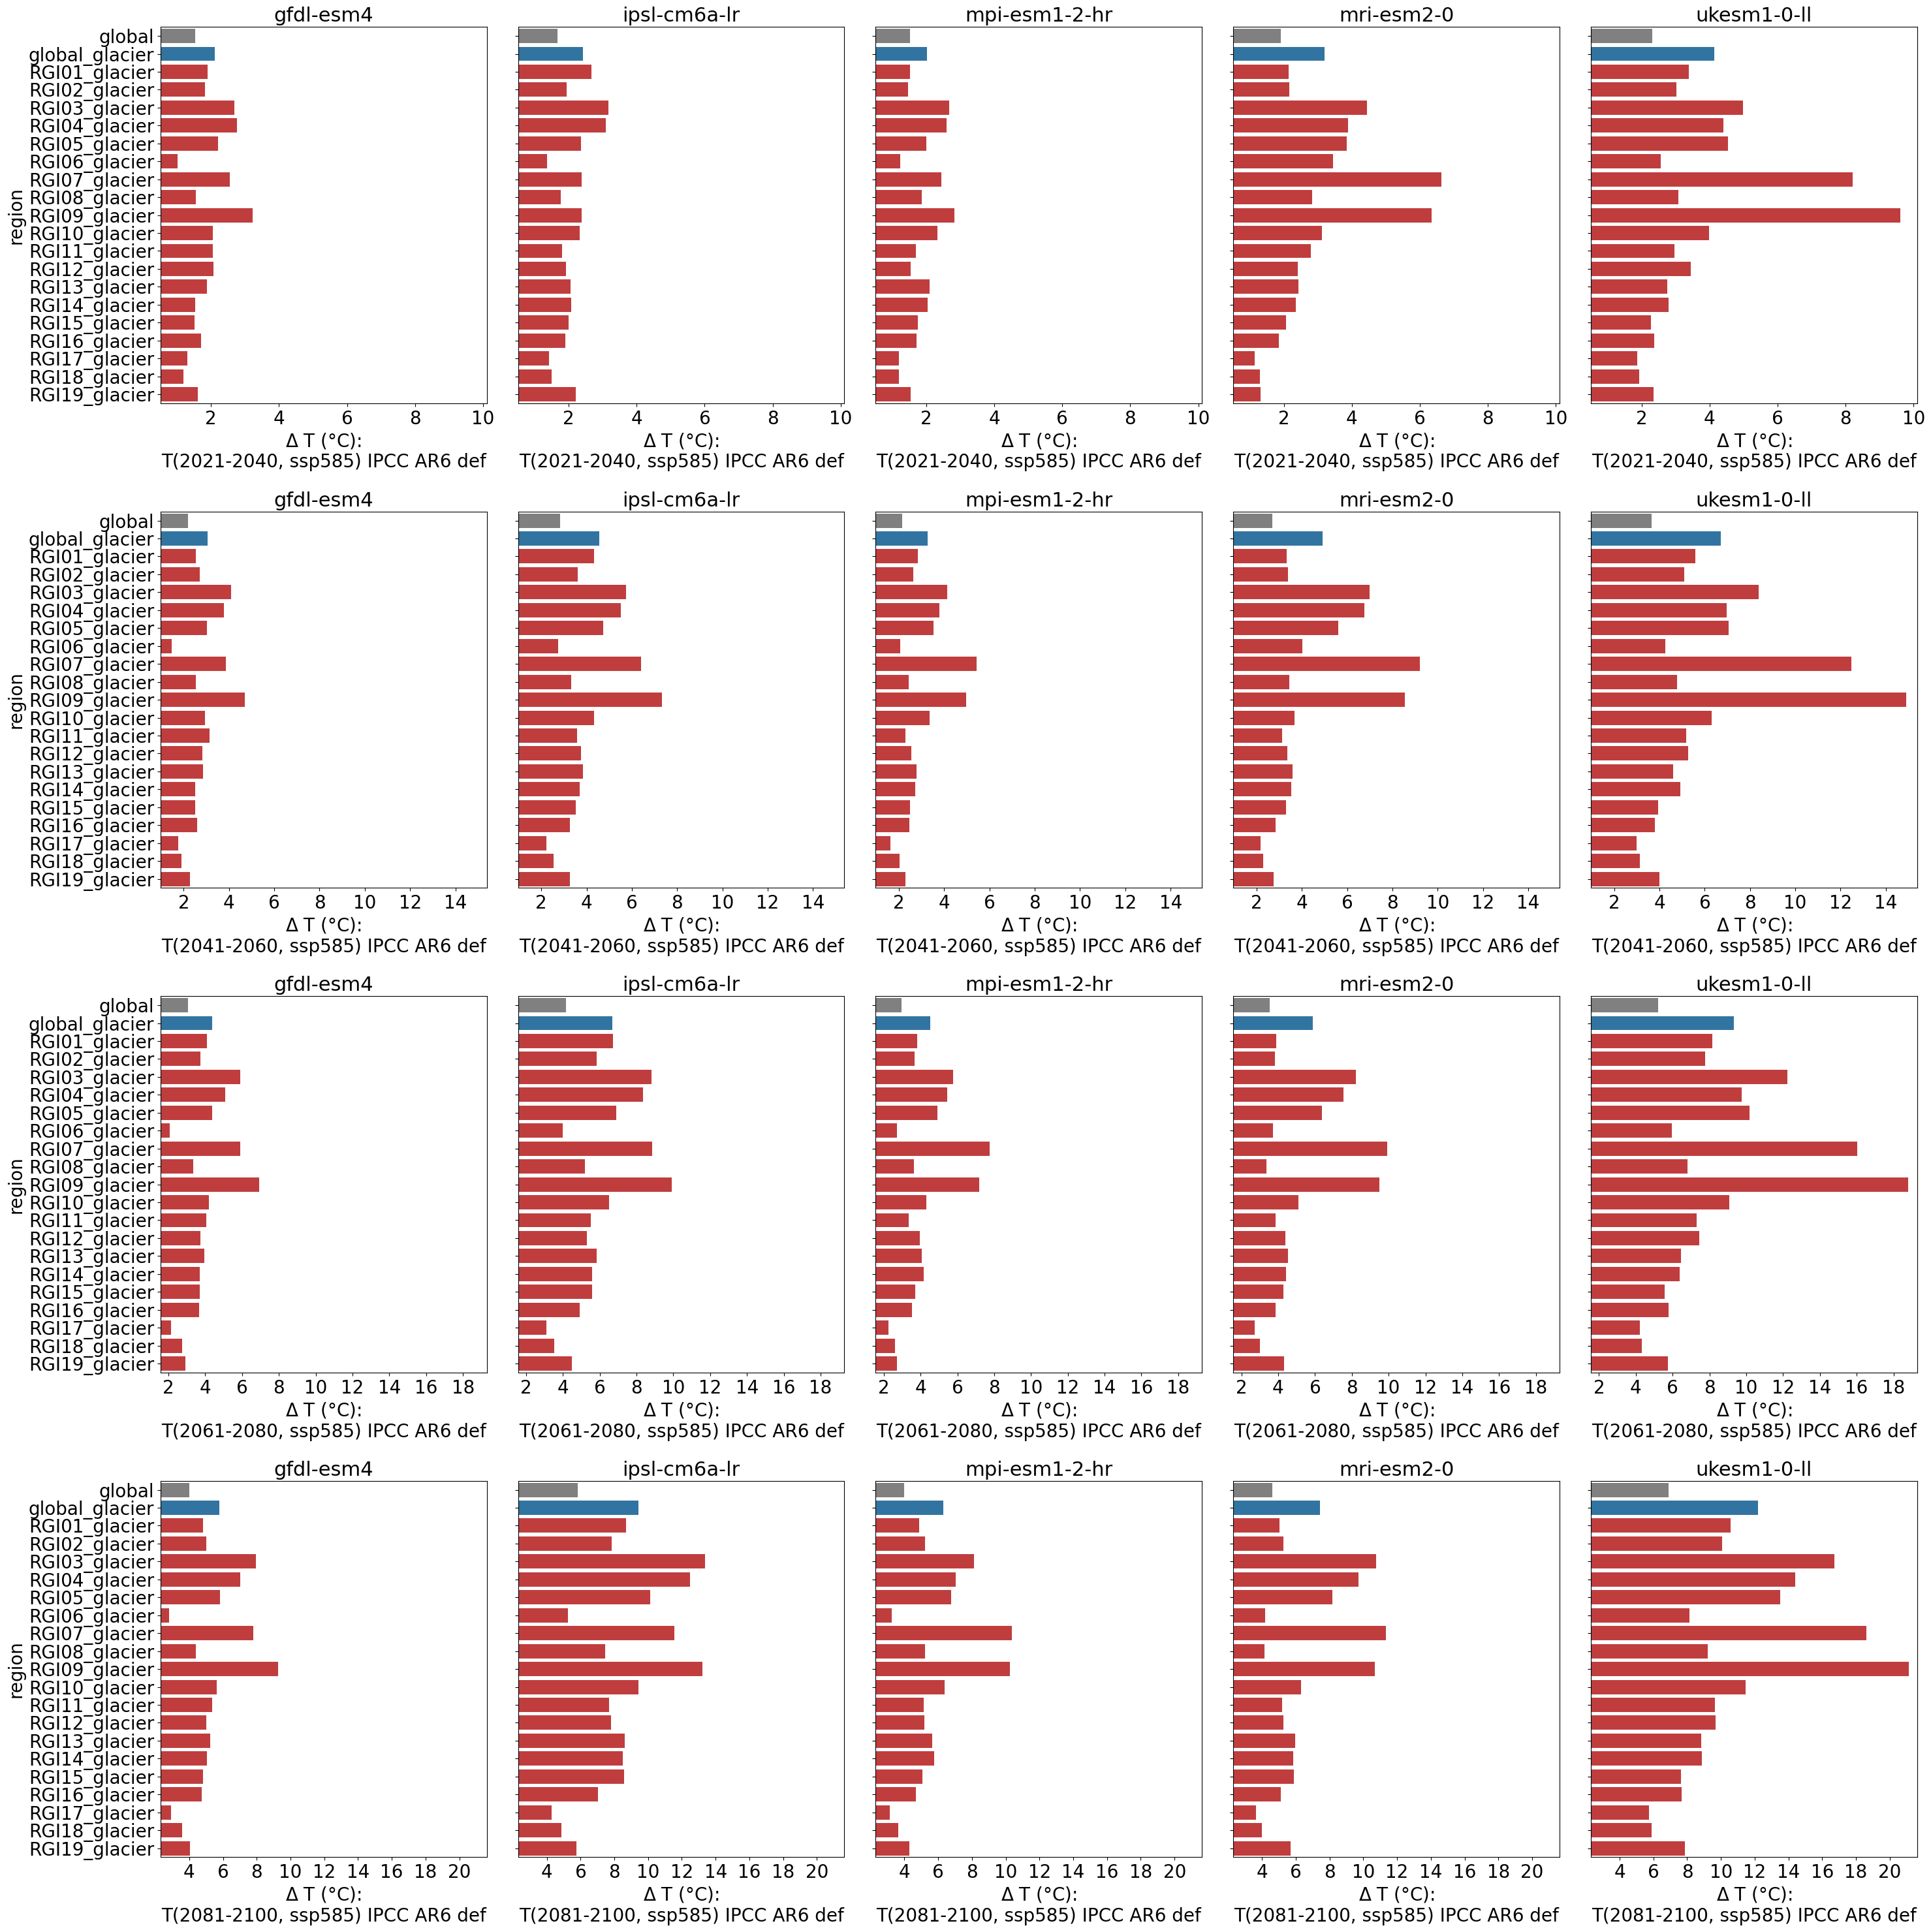

In [14]:
plt.rcParams.update({'font.size': 20})

for scenario in scenarios:
    fig,axss = plt.subplots(4,5, figsize=(30, 30),sharey=True)
    j = 0
    for exp_time in exp_times[4:]:
        axs = axss[j]
        period = f'{exp_time}-{exp_time+19}'
        pd_sel_ps = pd_global_temp_exp.loc[(pd_global_temp_exp.period_scenario==f'{period}_{scenario}')]
        jj = 0
        for gcm in gcms:
            ax = axs[jj]
            
            pd_sel = pd_sel_ps.loc[(pd_global_temp_exp.gcm==gcm)]
            pd_sel.index = pd_sel.region
            sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
                        palette=['grey', 'C0']+['C3'] * 19, ax=ax)
            ax.set_xlabel('$\Delta$ T (°C):\nT({}-{}, {}) IPCC AR6 def'.format(exp_time, exp_time+19, scenario), fontsize=20)
            if gcm==gcms[0]:
                ax.set_ylabel('region')
            else:
                ax.set_ylabel('')
            ax.set_xticks(np.arange(-14,22,2))
            maxi = pd_sel_ps['temp_ch_ipcc'].max() +0.5
            mini = pd_sel_ps['temp_ch_ipcc'].min() -0.5
            ax.set_xlim(mini, maxi)
            ax.set_title('{}'.format(gcm), fontsize=22)
            ax.tick_params(axis='y',which='minor',bottom=False)
            jj+=1
        j+=1
    plt.tight_layout()
    plt.savefig(f'figures/plots_climate_analysis/0_temp_change_global_regional_glacier_{scenario}.png')

***Past experiments***

/tmp/ipykernel_790705/2470814639.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
/tmp/ipykernel_790705/2470814639.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
/tmp/ipykernel_790705/2470814639.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
/tmp/ipykernel_790705/2470814639.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hu

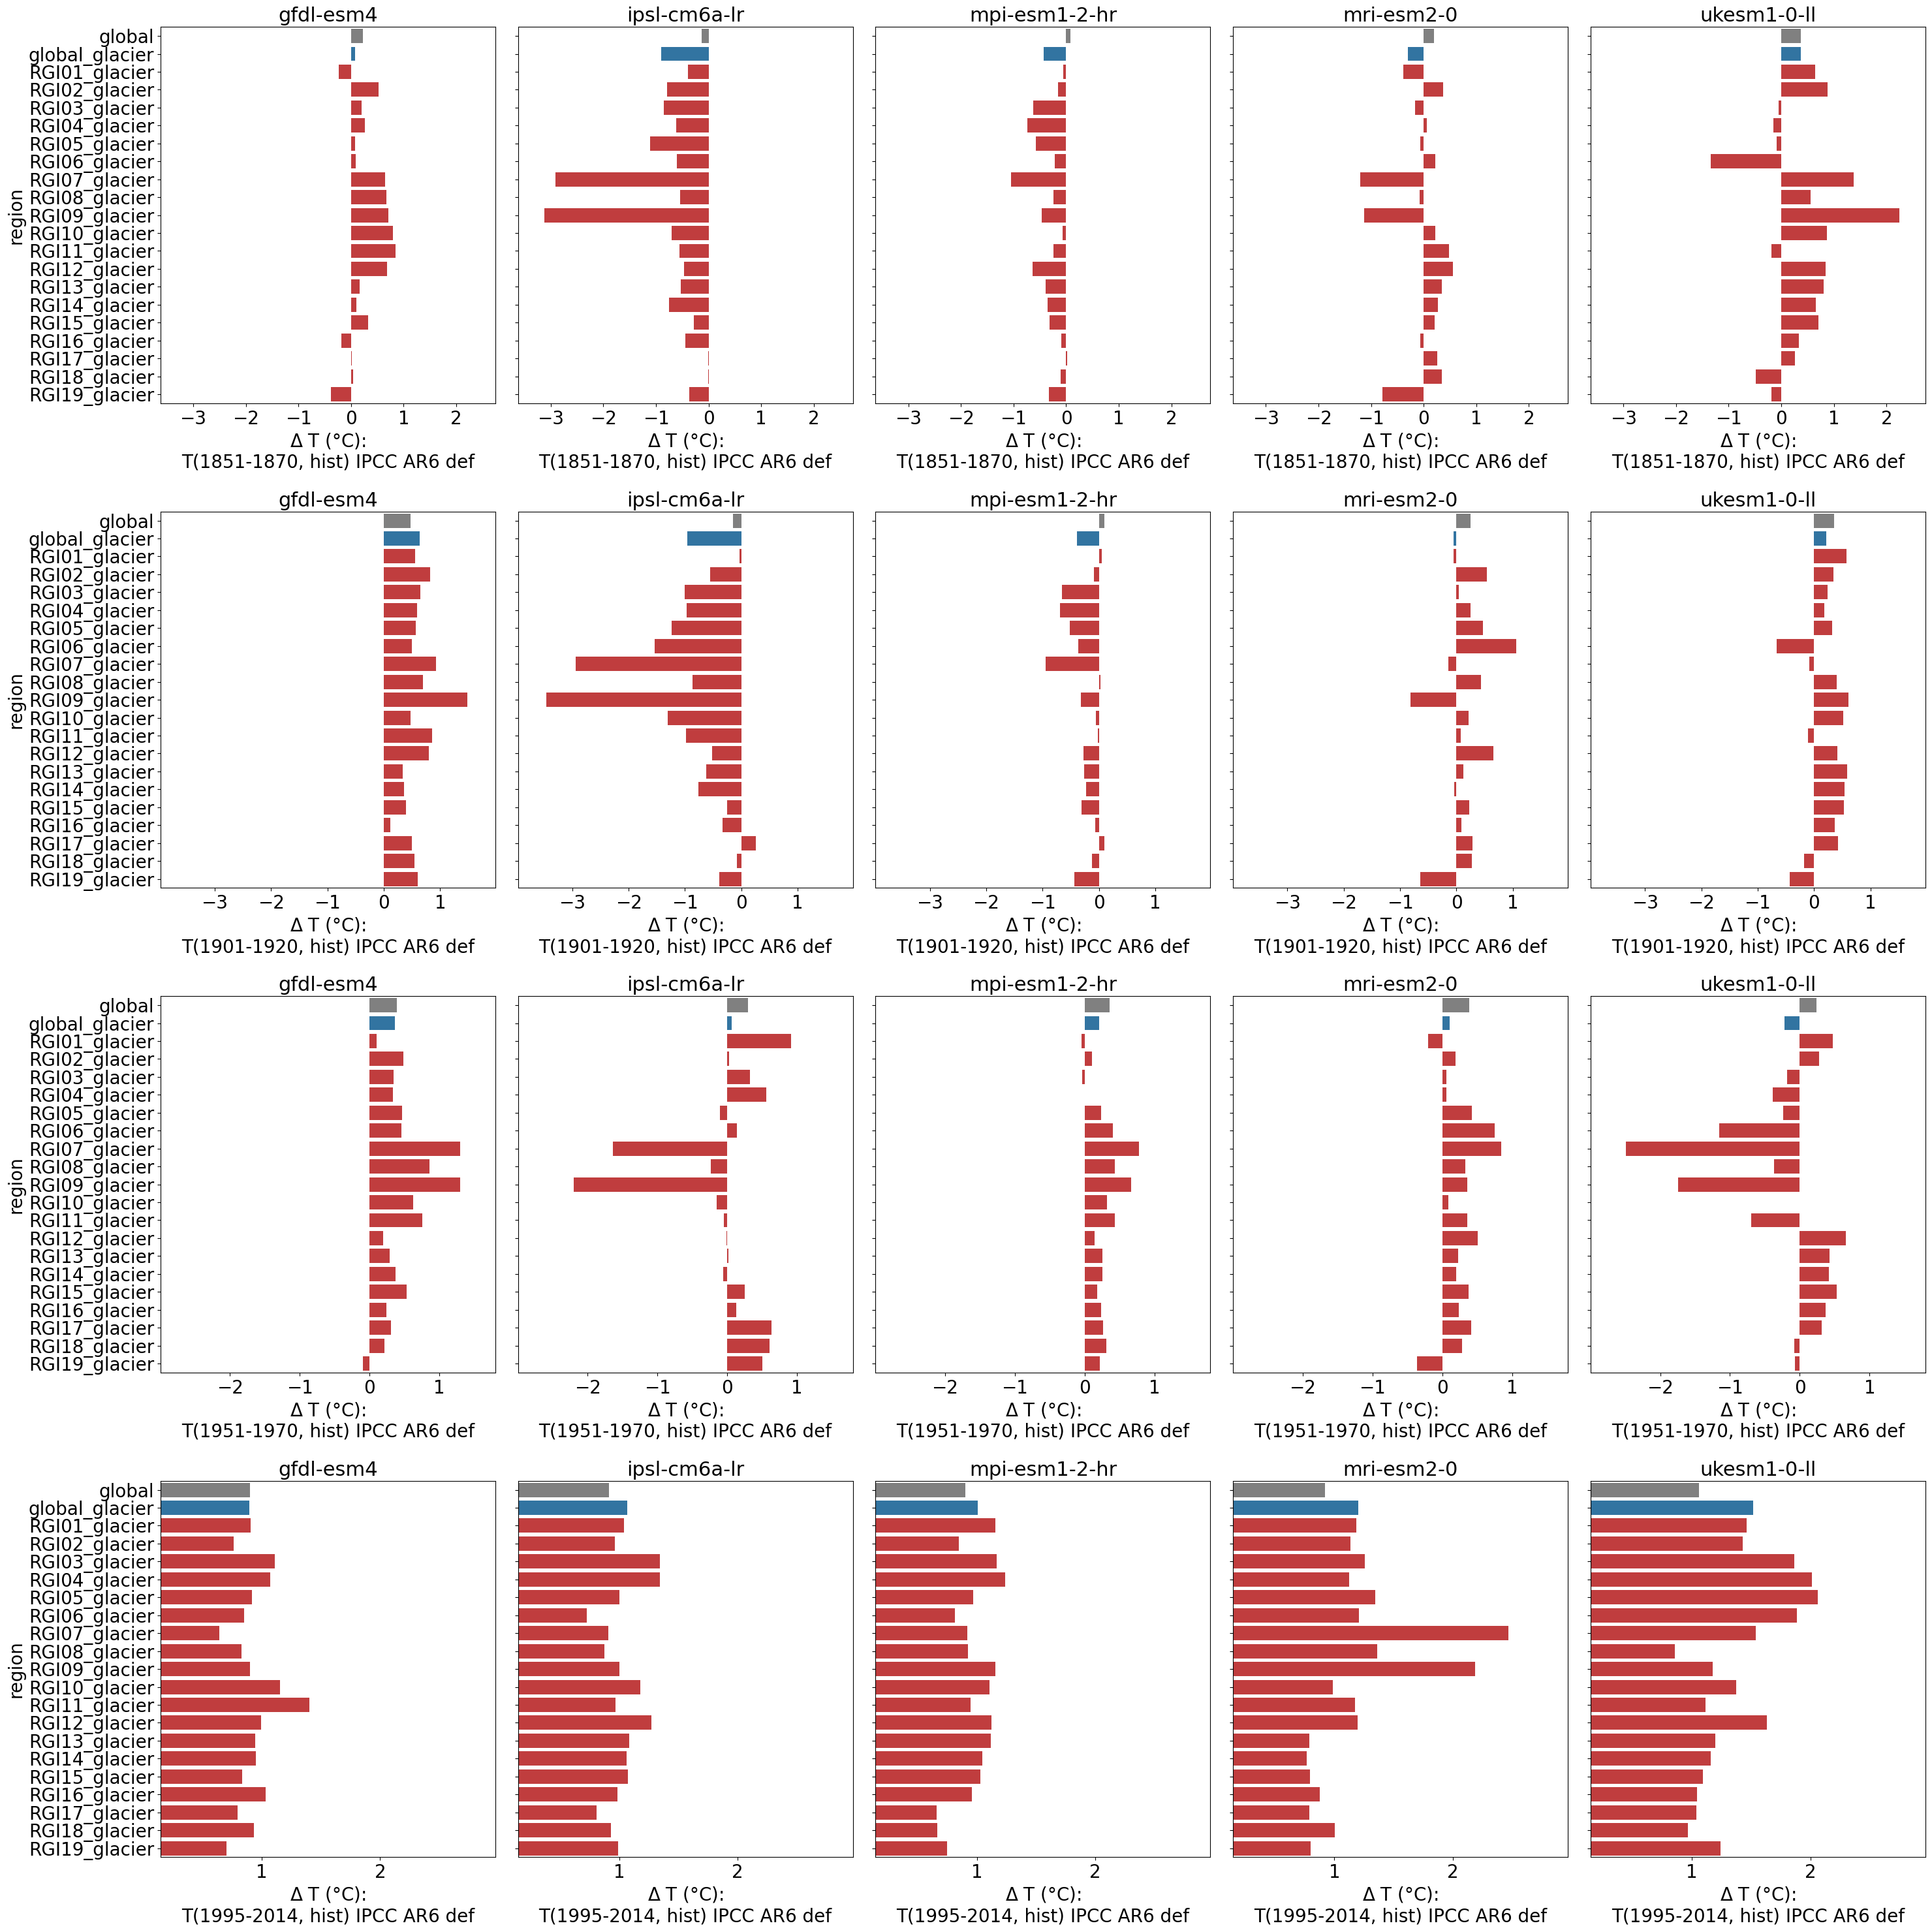

In [15]:
plt.rcParams.update({'font.size': 20})

scenario = 'hist'
fig,axss = plt.subplots(4,5, figsize=(30, 30),sharey=True)
j = 0
for exp_time in exp_times[:4]:
    axs = axss[j]
    period = f'{exp_time}-{exp_time+19}'
    pd_sel_ps = pd_global_temp_exp.loc[(pd_global_temp_exp.period_scenario==f'{period}_{scenario}')]
    jj = 0
    for gcm in gcms:
        ax = axs[jj]

        pd_sel = pd_sel_ps.loc[(pd_global_temp_exp.gcm==gcm)]
        pd_sel.index = pd_sel.region

        sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
                    palette=['grey', 'C0']+['C3'] * 19, ax=ax)
        ax.set_xlabel('$\Delta$ T (°C):\nT({}-{}, {}) IPCC AR6 def'.format(exp_time, exp_time+19, scenario), fontsize=20)
        if gcm==gcms[0]:
            ax.set_ylabel('region')
        else:
            ax.set_ylabel('')
        ax.set_xticks(np.arange(-14,22,1))
        maxi = pd_sel_ps['temp_ch_ipcc'].max() +0.5
        mini = pd_sel_ps['temp_ch_ipcc'].min() -0.5
        ax.set_xlim(mini, maxi)
        ax.set_title('{}'.format(gcm), fontsize=22)
        ax.tick_params(axis='y',which='minor',bottom=False)
        jj+=1
    j+=1
plt.tight_layout()
plt.savefig(f'figures/plots_climate_analysis/0_temp_change_global_regional_glacier_{scenario}.png')